# Problem statement

We are going to solve the 1D diffusion equation with a plethora of algorithms. 

They fall into two groups: explicit and implicit. The first one is consecutive since a few past steps describe the next step. Whereas, the implicit way is based on one past step impacting several future ones. To resolve the system of linear equations resulting from that we can implement some iterative applied math algorithms: Jacobi, Gauss-Seidel, and SSOR. Also, the Crank-Nicolson method includes both approaches as a partially implicit method. Additionally, we compare them to a solver from the scipy package.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import scipy.linalg
import random

import time

from numba import njit

# methods

In [2]:
@njit
def the_jakobi_solver(A_j, b_j, epsilon_j=0.1):
  #the formula for the Jakobi method: Tnew= D-1 * ( b - (L+U)*Told )     <--- source: wikipedia
  U_plus_L_j, D_inv_j = np.copy(A_j), np.linalg.inv(np.diag(np.diag(A_j)))
  np.fill_diagonal(U_plus_L_j, 0)

  Told_j=np.zeros_like(b_j)

  while np.sum(np.abs((np.dot(A_j, Told_j) - b_j))) > epsilon_j:
    Tnew_j=np.dot(D_inv_j,(b_j - np.dot(U_plus_L_j,Told_j)))
    Told_j=Tnew_j
  
  return Told_j

In [3]:
@njit
def the_gauss_seidel_solver(A_gs, b_gs, epsilon_gs=0.1):
  #the formula for the Gauss-Seidel method: Tnew = (L+D)−1 * (b − U*Told)     <--- source: wikipedia
  U_gs = np.copy(A_gs)
  for q in range(np.shape(A_gs)[0]):
    for t in range(q, np.shape(A_gs)[0]):           
      U_gs[t,q]=0                               #the upper triangle of the matrix
  L_plus_D_gs_inv = np.linalg.inv(A_gs-U_gs)    #the A matrix without the upper triangle is inverted by numpy magic

  Told_gs=np.zeros_like(b_gs)

  while np.sum(np.abs((np.dot(A_gs, Told_gs) - b_gs))) > epsilon_gs:
    Tnew_gs=np.dot(L_plus_D_gs_inv, (b_gs - np.dot(U_gs,Told_gs)))
    Told_gs=Tnew_gs

  return Told_gs

In [4]:
@njit
def the_ssor_solver(A_ss, b_ss, w_ss, epsilon_ss=0.1):
  #http://www.nhcue.edu.tw/~jinnliu/teaching/nde07/Lecture6.pdf   <-- source
  #the formula for the SSOR method: Tnew[k]= B1*B2*Told[k] + ω*(2 − ω)*(D + ωU)−1 * D * (D + ωL)−1 * b
  #B1 = (D + ωU)−1 (−ωL + (1 − ω)D) : Backward SOR Sweep
  #B2 = (D + ωL)−1 (−ωU + (1 − ω)D) : Forward SOR Sweep
  
  U_ss, L_ss, D_ss = np.copy(A_ss), np.copy(A_ss), np.zeros_like(A_ss)
  for q in range(np.shape(A_ss)[0]):
    for t in range(q, np.shape(A_ss)[0]):           
      U_ss[t,q]=0               #the upper triangle of the matrix
      L_ss[q,t]=0               #the lower triangle of the matrix
    D_ss[q,q]=A_ss[q,q]         #the main diagonal

  echo=np.linalg.inv(D_ss + w_ss*U_ss)          #(D+wU)-1
  foxtrot=np.linalg.inv(D_ss + w_ss*L_ss)       #(D+wL)-1
  golf=-w_ss*L_ss + (1 - w_ss)*D_ss             #(−ωL + (1 − ω)D)
  hotel=-w_ss*U_ss + (1 - w_ss)*D_ss            #(−ωU + (1 − ω)D)

  india=np.dot(np.dot(echo, golf), np.dot(foxtrot, hotel))                  #B1*B2
  juliet=np.dot(w_ss*(2-w_ss)*echo, np.dot(D_ss, np.dot(foxtrot, b_ss)))    #ω*(2 − ω)*(D + ωU)−1 * D * (D + ωL)−1 * b
  
  Told_ss=np.zeros_like(b_ss)

  while np.sum(np.abs((np.dot(A_ss, Told_ss) - b_ss))) > epsilon_ss:
    Tnew_ss=np.dot(india, Told_ss) + juliet
    Told_ss=Tnew_ss

  return Told_ss

# definators

In [5]:
def random_conditions_creator(nnx=0, Tleft=None, Tright=None, Tins=None, 
                              kappa=0, dt=0, h=0, s=0, epsilon=0, epsilon2=0, w=0):
  if not nnx: 
    nnx=np.random.randint(3,8)
    
  if not Tleft:
    Tleft = np.random.uniform(-273, 1000)
  if not Tright:
    Tright = np.random.uniform(-273, 1000)
  if not Tins:
    Tins = np.random.uniform(-273, 1000)

  if kappa and dt and h:
    if (dt > (h**2)/(2*kappa)) or (s >= 0.25):
      return 'Please, make sure that your diffusivity, dt, and h suit for stability conditions'
    else: 
      s=(kappa * dt)/(h**2)
  if not s:
    s=np.random.uniform(1e-3,0.24)          #it should be limited by 0.25
  
  if not epsilon:
    epsilon=np.random.uniform(1e-4,1e-2)    #error for the matrix convergeance
  if not epsilon2:
    epsilon2=np.random.uniform(1e-3,1)      #tolerance with the diffution equalibrium condition

  if not w:
    w=np.random.uniform(1e-10,2)            #parament for the SSOR method (0,2)
  
  return (nnx, Tleft, Tright, Tins, s, epsilon, epsilon2, w)

In [6]:
@njit
def matrix_creator(nnx_m,s_m):
  #implicit matrix
  A_m=np.zeros((nnx_m,nnx_m))
  for i in range(1, nnx_m-1):
    A_m[i][i]=1 + 2*s_m
    A_m[i][i-1]=-s_m
    A_m[i][i+1]=-s_m
  A_m[0][0], A_m[nnx_m-1, nnx_m-1]=1, 1

  #explicit matrix
  B_m=np.zeros((nnx_m,nnx_m))
  for i in range(1, nnx_m-1):
    B_m[i][i]=1 - 2*s_m
    B_m[i][i-1]=s_m
    B_m[i][i+1]=s_m
  B_m[0][0], B_m[nnx_m-1, nnx_m-1]=1, 1
  
  return (A_m, B_m)

In [7]:
@njit
def b_vector_creator(nnx_b, Tleft_b, Tright_b, Tins_b):
  b_b=np.ones(nnx_b)*Tins_b                   #initial field
  b_b[0], b_b[nnx_b-1]= Tleft_b, Tright_b     #boundary conditions
  return b_b

In [8]:
def diffution_with_jakobi_implicit(matrix_A_d, b_vector_d, Tleft_d, Tright_d, epsilon_d, epsilon2_d):
  nnx_d=np.shape(b_vector_d)[0]
  dif_finish_d=np.arange(Tleft_d, 
                         Tright_d + 0.5*(Tright_d - Tleft_d)/(nnx_d-1), 
                         (Tright_d - Tleft_d)/(nnx_d-1))  #the final equilibrium
  tend=time.time()+0.5      #<-- prevent too long loops

  while (np.mean(np.abs(b_vector_d - dif_finish_d)) > epsilon2_d) and (time.time() < tend):
    Tnew_d=the_jakobi_solver(matrix_A_d, b_vector_d, epsilon_j=epsilon_d)
    b_vector_d[:]=Tnew_d[:]

  return b_vector_d

In [9]:
def diffution_with_gauss_seidel_implicit(matrix_A_g, b_vector_g, Tleft_g, Tright_g, epsilon_g, epsilon2_g):
  nnx_g=np.shape(b_vector_g)[0]
  dif_finish_g=np.arange(Tleft_g, 
                         Tright_g + 0.5*(Tright_g - Tleft_g)/(nnx_g-1), 
                         (Tright_g - Tleft_g)/(nnx_g-1))  #the final equilibrium

  while np.mean(np.abs(b_vector_g - dif_finish_g)) > epsilon2_g:
    Tnew_g=the_gauss_seidel_solver(matrix_A_g, b_vector_g, epsilon_gs=epsilon_g)
    b_vector_g[:]=Tnew_g[:]

  return b_vector_g

In [10]:
def diffution_with_scipy_implicit(matrix_A_s, b_vector_s, Tleft_s, Tright_s, epsilon2_s):
  nnx_s=np.shape(b_vector_s)[0]
  dif_finish_s=np.arange(Tleft_s, 
                         Tright_s + 0.5*(Tright_s - Tleft_s)/(nnx_s-1), 
                         (Tright_s - Tleft_s)/(nnx_s-1))  #the final equilibrium

  while np.mean(np.abs(b_vector_s - dif_finish_s)) > epsilon2_s:
    Tnew_s=scipy.linalg.solve(matrix_A_s, b_vector_s)     #solver from the scipy.linalg package
    b_vector_s[:]=Tnew_s[:]

  return b_vector_s

In [11]:
def diffution_with_ssor_implicit(matrix_A_ds, b_vector_ds, Tleft_ds, Tright_ds, epsilon_ds, epsilon2_ds, w_ds):
  nnx_ds=np.shape(b_vector_ds)[0]
  dif_finish_ds=np.arange(Tleft_ds, 
                          Tright_ds + 0.5*(Tright_ds - Tleft_ds)/(nnx_ds-1), 
                          (Tright_ds - Tleft_ds)/(nnx_ds-1))  #the final equilibrium

  while np.mean(np.abs(b_vector_ds - dif_finish_ds)) > epsilon2_ds:
    Tnew_ds=the_ssor_solver(matrix_A_ds, b_vector_ds, w_ds, epsilon_ss=epsilon_ds)
    b_vector_ds[:]=Tnew_ds[:]

  return b_vector_ds

In [12]:
def diffution_with_explicit(matrix_B_e, b_vector_e, Tleft_e, Tright_e, epsilon2_e):
  nnx_e=np.shape(b_vector_e)[0]
  dif_finish_e=np.arange(Tleft_e, 
                         Tright_e + 0.5*(Tright_e - Tleft_e)/(nnx_e-1), 
                         (Tright_e - Tleft_e)/(nnx_e-1))  #the final equilibrium

  while np.mean(np.abs(b_vector_e - dif_finish_e)) > epsilon2_e:
    Tnew_e=np.dot(matrix_B_e, b_vector_e)
    b_vector_e[:]=Tnew_e[:]

  return b_vector_e

In [13]:
def diffution_with_crank_nicolson_implicit(matrix_cn, b_vector_cn, Tleft_cn, Tright_cn, epsilon2_cn):
  #the formula for the Crank-Nicolson method is: Tnew = A−1 (B * Told)     <--- source: wikipedia
  #where A is the implicit matrix and B is the explicit matrix
  nnx_cn=np.shape(b_vector_cn)[0]
  dif_finish_cn=np.arange(Tleft_cn, 
                          Tright_cn + 0.5*(Tright_cn - Tleft_cn)/(nnx_cn-1), 
                          (Tright_cn - Tleft_cn)/(nnx_cn-1))

  while np.mean(np.abs(b_vector_cn - dif_finish_cn)) > epsilon2_cn:
    Tnew_cn=np.dot(np.linalg.inv(matrix_cn[0]), 
                   np.dot(matrix_cn[1], b_vector_cn))
    b_vector_cn[:]=Tnew_cn[:]

  return b_vector_cn

# Battle

In [14]:
R=random_conditions_creator()
#output is (nnx 0, Tleft 1, Tright 2, Tins 3, s 4, epsilon 5, epsilon2 6, w 7)

k=b_vector_creator(R[0], R[1], R[2], R[3])
C=matrix_creator(R[0], R[4])
#output is (A for implicit, B for explicit)

time1=time.time()
#input is (matrix_A, b_vector, Tleft, Tright, epsilon, epsilon2)
diffution_with_jakobi_implicit(C[0], k, R[1], R[2], R[5], R[6])
time2=time.time()

time3=time.time()
#input is (matrix_A, b_vector, Tleft, Tright, epsilon2)
diffution_with_scipy_implicit(C[0], k, R[1], R[2], R[6])
time4=time.time()

time5=time.time()
#input is (matrix_B, b_vector, Tleft, Tright, epsilon2)
diffution_with_explicit(C[1], k, R[1], R[2], R[6])
time6=time.time()

time7=time.time()
#input is (matrix_A, b_vector, Tleft, Tright, epsilon, epsilon2, w)
diffution_with_ssor_implicit(C[0], k, R[1], R[2], R[5], R[6], R[7])
time8=time.time()

time9=time.time()
#input is (matrix_A, b_vector, Tleft, Tright, epsilon, epsilon2)
diffution_with_gauss_seidel_implicit(C[0], k, R[1], R[2], R[5], R[6])
time10=time.time()

time11=time.time()
#input is (matrix, b_vector, Tleft, Tright, epsilon2)
diffution_with_crank_nicolson_implicit(C, k, R[1], R[2], R[6])
time12=time.time()

tJ, ts, tex = time2 - time1, time4 - time3, time6 - time5
tss, tgs, tcn = time8 - time7, time10 - time9, time12 - time11
r={tJ: 'the Jakobi algorithm', ts: 'the scipy method', tex: 'the explicit method', 
   tss: 'the SSOR algorithm', tgs: 'the Gauss-Seidel algorithm', tcn: 'the Crank-Nicolson method'}
                                                                                  
print(f'''The given data are: the lenght is {R[0]}, the error boundary is {R[6]:.2f}
The left and right boundaries are {R[1]:.2f} and {R[2]:.2f} with the initial temperature being {R[3]:.2f}

Time spent by the Jakobi algorithm is {tJ:.2e} seconds
Time spent by the scipy method is {ts:.2e} seconds
Time spent by the explicit method is {tex:.2e} seconds
Time spent by the SSOR algoritm is {tss:.2e} seconds
Time spent by the Gauss-Seidel algorithm is {tgs:.2e} seconds
Time spent by the Crank-Nicolson method is {tcn:.2e} seconds

The fastest forestgamp is {r[min(dict.keys(r))]}''')

The given data are: the lenght is 4, the error boundary is 0.18
The left and right boundaries are 557.42 and -266.22 with the initial temperature being 208.61

Time spended by the Jakobi algorithm is 1.12e+01 seconds
Time spended by the scipy method is 3.40e-03 seconds
Time spended by the explicit method is 1.90e-04 seconds
Time spended by the SSOR algoritm is 2.51e-04 seconds
Time spended by the Gauss-Seidel algorithm is 2.03e-04 seconds
Time spended by the Crank-Nicolson method is 1.69e-04 seconds

The fastest forestgamp is the Crank-Nicolson method


In [15]:
def loser_choser():
  R_lc=random_conditions_creator()
  k_lc=b_vector_creator(R_lc[0], R_lc[1], R_lc[2], R_lc[3])
  C_lc=matrix_creator(R_lc[0], R_lc[4])

  time1_lc=time.time() 
  diffution_with_jakobi_implicit(C_lc[0], k_lc, R_lc[1], R_lc[2], R_lc[5], R_lc[6])
  time2_lc=time.time()

  time3_lc=time.time()
  diffution_with_scipy_implicit(C_lc[0], k_lc, R_lc[1], R_lc[2], R_lc[6])
  time4_lc=time.time()

  time5_lc=time.time()
  diffution_with_explicit(C_lc[1], k_lc, R_lc[1], R_lc[2], R_lc[6])
  time6_lc=time.time()

  time7_lc=time.time()
  diffution_with_ssor_implicit(C_lc[0], k_lc, R_lc[1], R_lc[2], R_lc[5], R_lc[6], R_lc[7])
  time8_lc=time.time()

  time9_lc=time.time()
  diffution_with_gauss_seidel_implicit(C_lc[0], k_lc, R_lc[1], R_lc[2], R_lc[5], R_lc[6])
  time10_lc=time.time()

  time11_lc=time.time()
  diffution_with_crank_nicolson_implicit(C_lc, k_lc, R_lc[1], R_lc[2], R_lc[6])
  time12_lc=time.time()

  tJ_lc, ts_lc, tex_lc, tss_lc, tgs_lc, tcn_lc = [time2_lc - time1_lc, time4_lc - time3_lc, 
                                                  time6_lc - time5_lc, time8_lc - time7_lc, 
                                                  time10_lc - time9_lc, time12_lc - time11_lc]
  r_lc={tJ_lc: 'the Jakobi algoritm', ts_lc: 'the scipy method', 
        tex_lc: 'the explicit method', tss_lc: 'the SSOR algoritm', 
        tgs_lc: 'the Gauss-Seidel algoritm', tcn_lc: 'the Crank-Nicolson method'}

  #return 'Jakobi time', 'scipy time', 'explicit time', 'SSOR time', 'Gauss-Seidel time', 'Crack-Nicolson time', 
  #       'nnx', 's', 'error1', 'error2', 'winner'
  return (tJ_lc, ts_lc, tex_lc, tss_lc, tgs_lc, tcn_lc, 
          str(R_lc[0]), R_lc[4], R_lc[5], R_lc[6], r_lc[min(dict.keys(r_lc))])

In [16]:
amount_of_methods=6

In [17]:
np.random.seed(333)

In [18]:
cols = ['Jakobi time', 'scipy time', 'explicit time', 'SSOR time', 'Gauss-Seidel time', 
        'Crack-Nicolson time', 'nnx', 's', 'error1', 'error2', 'winner']

df = pd.DataFrame(columns = cols)           #creating a the main dataframe

for m in range(5000):                       #for 5000 cycles there is ~ 1,5 min required
  df.loc[m] = loser_choser()                #filling the df with obtained results
df.sort_values(by=['nnx'], inplace=True)    #sorting by nnx
df

,Jakobi time,scipy time,explicit time,SSOR time,Gauss-Seidel time,Crack-Nicolson time,nnx,s,error1,error2,winner
4166,0.001725,0.000018,0.000015,0.000014,0.000013,0.000013,3,0.042487,0.006814,0.334158,the Crank-Nicolson method
971,0.028807,0.000044,0.000033,0.000030,0.000029,0.000029,3,0.003982,0.005778,0.528253,the Crank-Nicolson method
2630,0.000858,0.000020,0.000016,0.000014,0.000014,0.000013,3,0.114136,0.005889,0.187958,the Crank-Nicolson method
4495,0.000423,0.000018,0.000015,0.000015,0.000014,0.000013,3,0.216869,0.008178,0.699132,the Crank-Nicolson method
966,0.001122,0.000017,0.000014,0.000014,0.000013,0.000013,3,0.045892,0.002403,0.191321,the Crank-Nicolson method
...,...,...,...,...,...,...,...,...,...,...,...
2841,0.061285,0.000034,0.000016,0.000016,0.000014,0.000014,7,0.007280,0.001335,0.664338,the Crank-Nicolson method
2836,0.009188,0.000021,0.000015,0.000014,0.000014,0.000013,7,0.054897,0.006454,0.907077,the Crank-Nicolson method
2830,0.003745,0.000017,0.000014,0.000014,0.000013,0.000013,7,0.230928,0.000177,0.333714,the Crank-Nicolson method
4158,0.001948,0.000026,0.000022,0.000022,0.000021,0.000020,7,0.220642,0.000907,0.908393,the Crank-Nicolson method


In [19]:
# for a nice boxplot further below i can come out only with a workaround like that
# tidy data
cols2 = ['log10(time)', 'method', 'nnx']
df2 = pd.DataFrame(columns = cols2)

for i in range(amount_of_methods):
  for j in range(1000):       #for 4 method the time is ~12 sec, for 5 ~16 sec, for 6 ~20 sec
    df2.loc[i*1000 + j] = (np.log10(df[cols[i]][j]), cols[i], df['nnx'][j])

df2.sort_values(by=['nnx'], inplace=True)

# results

In [170]:
l=df['winner'].value_counts()/len(df)
for y in range(len(l)):
  print(f"{l.index[y]} wins {round(100*l[y],3)}% of battles")

the Gauss-Seidel algoritm wins 78.78% of battles
the Crank-Nicolson method wins 16.32% of battles
the SSOR algoritm wins 3.92% of battles
the explicit method wins 0.88% of battles
the scipy method wins 0.1% of battles


Text(0, 0.5, 's')

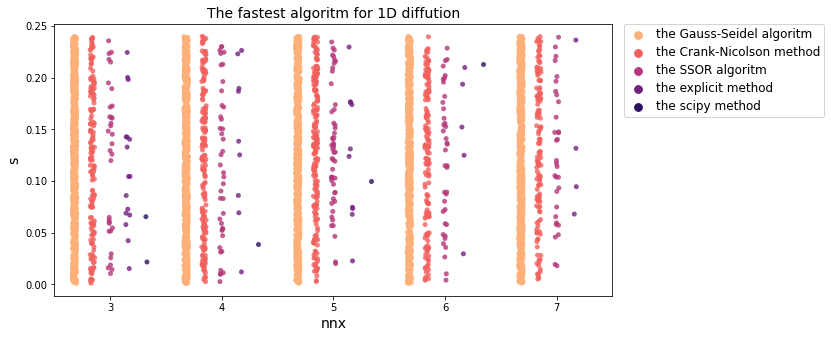

In [171]:
plt.figure(figsize=(10,5))
plt.title('The fastest algoritm for 1D diffution', fontsize=14)
pic = sns.stripplot(x='nnx', y='s', data=df, jitter=True, hue='winner', 
                    dodge=True, alpha=0.8, palette='magma_r')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(pic.get_legend().get_texts(), fontsize='12')
plt.xlabel('nnx', fontsize=14)
plt.ylabel('s', fontsize=14)
#plt.savefig('winner and nnx distribution.pdf')
#plt.savefig('winner and nnx distribution.png', transparent=True, dpi=300)

In [149]:
#if we would like to examine fastest algorisms more precisely
df3=df2.loc[df2['method'] != "Jakobi time"]

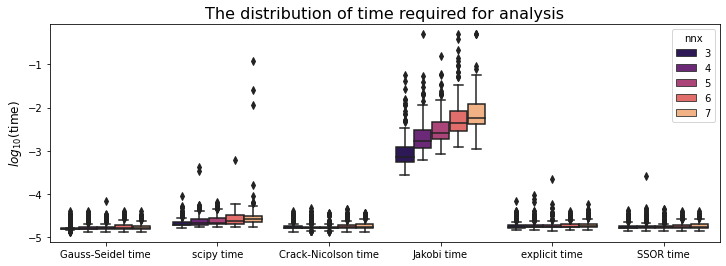

In [195]:
plt.figure(figsize=(12,4))
plt.title('The distribution of time required for analysis', fontsize=16)
sns.boxplot(y='log10(time)', x="method", hue='nnx', 
            palette="magma", saturation=0.8, data=df2)#.set(title=title)
plt.ylabel(r'$log_{10}$(time)', fontsize=12)
plt.xlabel('')
#plt.ylim(top=-4)

# plt.savefig('log10(time) vs nnx.pdf')
# plt.savefig('log10(time) vs nnx.png', transparent=True, dpi=300)

Please, take into account that due to super low speed of the Jakobi method, there is a blocker only for this method until 0,5 seconds of processing. Yet as it could be seen it blocks just outliers without any interference to the distribution. 

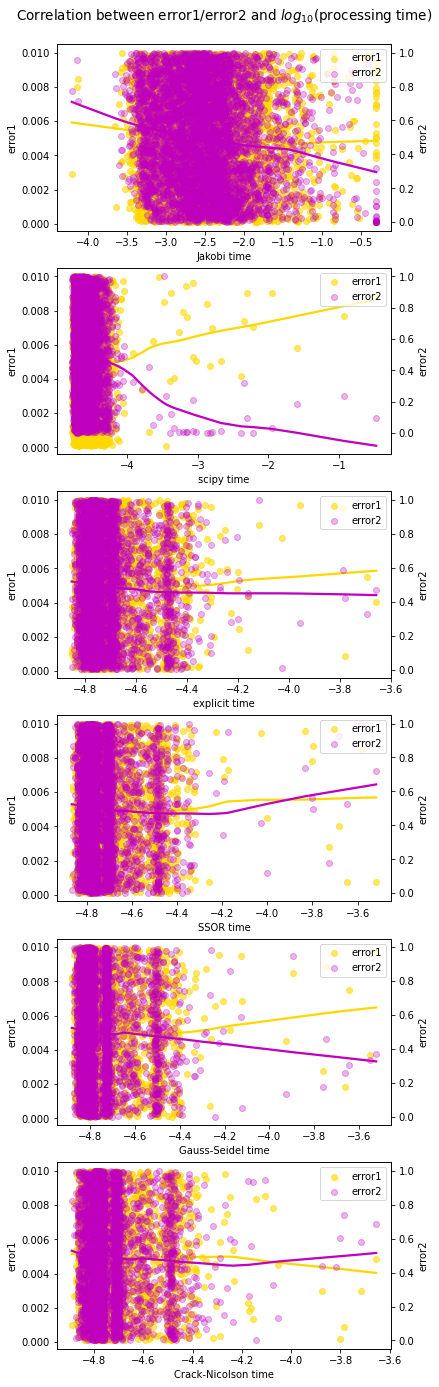

In [187]:
fig, axes = plt.subplots(amount_of_methods, 1, figsize=(6,4*amount_of_methods))

axes[0].set_title('Correlation between error1/error2 and ' 
                  + r'$log_{10}$(processing time)'+'\n', fontsize=13.5)

for i in range(amount_of_methods):
  er1 =sns.regplot(x=np.log10(df[cols[i]]), y=df["error1"], data=df, 
                   scatter=True, color='gold', scatter_kws={'alpha':0.6}, 
                   lowess=True, ax=axes[i], label='error1')
  er2 =sns.regplot(x=np.log10(df[cols[i]]), y=df["error2"], data=df, 
                   scatter=True, color='m', scatter_kws={'alpha':0.3}, 
                   lowess=True, ax=axes[i].twinx(), label='error2')
  # er1.set_xlim(-5,0)
  # er2.set_xlim(-5,0)

  lines, labels = er1.get_legend_handles_labels()
  lines2, labels2 = er2.get_legend_handles_labels()
  er2.legend(lines + lines2, labels + labels2, loc=1)

# fig.suptitle('\n \n Correlation between error1/error2 and ' 
#              + r'$log_{10}$(processing time)'+'\n', fontsize=16)

# plt.savefig('Time-error correclationbig2.pdf')
# plt.savefig('Time-error correclationbig2.png', transparent=True, dpi=300)

# Statistics

As we can see from the results nnx more clearly impacts the required time than both errors. Yet there could be some correlations which are not obvious. However, we are scientists so let's prove it!

In [21]:
df['nnx'] = df['nnx'].apply(int)

In [23]:
cordf=df.corr().drop(index=cols[:amount_of_methods], columns=cols[-5:-1])
cordf   #Pearson's correlation

,Jakobi time,scipy time,explicit time,SSOR time,Gauss-Seidel time,Crack-Nicolson time
nnx,0.145410,0.032184,0.078309,0.040163,0.068283,0.057458
s,-0.235475,-0.038606,-0.076830,-0.055808,-0.065913,-0.057770
error1,0.010981,0.024826,-0.022201,-0.025017,-0.021510,-0.008833
error2,-0.104619,-0.027352,-0.027221,-0.028236,-0.022813,-0.012147


As your data can be sparse, so Pearson's coeffitiant as a representation of linear could be not so illustrative as monotonic Spearman's.

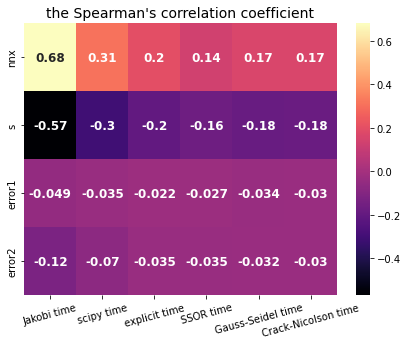

In [25]:
df_log=df.copy(deep=True)
for i in cols[:amount_of_methods]:
  df_log[i] = df_log[i].apply(np.log10)

cor_log=df_log.corr(method='spearman').drop(index=cols[:amount_of_methods], 
                                            columns=cols[-5:-1])

plt.figure(figsize=(7,5))
plt.title("the Spearman's correlation coefficient", fontsize=14)
sns.heatmap(cor_log, cmap='magma', annot=True, 
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
plt.xticks(rotation=15)

# plt.savefig('Spearman correlationbig1.pdf')
# plt.savefig('Spearman correlationbig1.png', transparent=True, dpi=300)

In [142]:
df.to_csv('raw_data.csv', index=False)
df2.to_csv('tidy_data.csv', index=False)